In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
from scipy import interpolate
from scipy.special import factorial
import h5py
import copy

# import personal code
import sys
sys.path.insert(0, '/home/jhen/XWCL/code/MagAOX/functions')
#import magaoxFunctions as mf
import psd_functions as psd
import zernike as zern
import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

In [2]:
fm_num=8 # pick one mirror
tot_step=6
fits_folder = 'flat_mirrors/fixed_fits/'

for ns in range(0, tot_step):
    print('Analyzing Step {0}'.format(ns))
    # call in the file
    fm_loc = 'flat_mirrors/2018_03_23/flat_2in_n{0}_100percent_step{1}.datx'.format(fm_num, ns)
    surf, mask, sp = dfx.open_datx(datx_file_loc=fm_loc, diam_ca100=50*u.mm)

    # tighten up the matrix by removing empty rows and columns
    surf, mask = dfx.mat_tight(surf, mask)

    # check that the matrix is even (required for the PSD code)
    if np.shape(surf)[0] % 2 != 0: # odd matrix
        surf, mask = dfx.mat_reduce(data=surf, mask=mask, side_reduce=1)

    # apply the changes onto the dictionary
    sp['diam_pix'] = np.shape(mask)[0]*u.pix
    sp['diam_mm'] = (sp['diam_pix'] * sp['lateral_res']).to(u.mm)
    
sp['diam_mm']

Analyzing Step 0
Analyzing Step 1
Analyzing Step 2
Analyzing Step 3
Analyzing Step 4
Analyzing Step 5


<Quantity 49.91087344 mm>

In [78]:
fm_num=8 # pick one mirror
tot_step=6
fits_folder = 'flat_mirrors/fixed_fits/'

for ns in range(0, tot_step):
    print('Analyzing Step {0}'.format(ns))
    # call in the file
    fm_loc = 'flat_mirrors/2018_03_23/flat_2in_n{0}_100percent_step{1}.datx'.format(fm_num, ns)
    surf, mask, sp = dfx.open_datx(datx_file_loc=fm_loc, diam_ca100=50*u.mm)

    # tighten up the matrix by removing empty rows and columns
    surf, mask = dfx.mat_tight(surf, mask)

    # check that the matrix is even (required for the PSD code)
    if np.shape(surf)[0] % 2 != 0: # odd matrix
        surf, mask = dfx.mat_reduce(data=surf, mask=mask, side_reduce=1)

    # apply the changes onto the dictionary
    sp['diam_pix'] = np.shape(mask)[0]*u.pix
    sp['diam_mm'] = (sp['diam_pix'] * sp['lateral_res']).to(u.mm)

    # save the raw file
    raw_file = fits_folder+'flat_2in_n{0}_step{1}_raw'.format(fm_num, ns)
    #dfx.write_fits(surface=surf, mask=mask, surf_parms=sp, filename=raw_file, save_mask=False)

    #Convert surface data to phase'
    k_num = sp['wavelength'].to(surf.unit) / (2*np.pi*u.radian)
    surf_phase = surf / k_num

    # Calculate Zernike PTT presence in data and remove it
    surf_fix_phase, w_ptt = zern.remove_ptt(data=surf_phase, mask=mask)
    
    # remove up to zernike 9
    '''
    z_weight = []
    surf_fix_phase = copy.copy(surf_phase) # intitialize 
    zn = [0, 1, 2, 3]
    for nv in zn:
        zm = np.linspace(-nv,nv,num=nv+1,endpoint=True).astype(int)
        for mv in zm:
            print('Correcting zernike n={0} m={1}'.format(nv, mv))
            z_phase, w_val = zern.calc_zernike_proj(data=surf_fix_phase, mask=mask, zn=nv, zm=mv)
            surf_fix_phase = surf_fix_phase - (z_phase*w_val)
            z_weight.append(w_val)
    '''

    # change the surface back into units of OPD
    surf_fix = surf_fix_phase * k_num
    
    # write data to a matrix
    if ns==0: # initialize first time
        data_set = np.zeros((tot_step, np.shape(mask)[0], np.shape(mask)[0])) # initialize first
    data_set[ns, :, :] = surf_fix.value

    # write all this to a FITS file
    fits_file = fits_folder+'flat_2in_n{0}_step{1}'.format(fm_num, ns)
    #dfx.write_fits(surface=surf_fix, mask=mask, surf_parms=sp, filename=fits_file)

# apply units to the data set
data_set *= surf_fix.unit
w_ptt

Analyzing Step 0
Analyzing Step 1
Analyzing Step 2
Analyzing Step 3
Analyzing Step 4
Analyzing Step 5


[5.302977750203405, -2.0790806949734915, -0.04131300662886963]

In [8]:
fm_num=8 # pick one mirror
tot_step=6
fits_folder = 'flat_mirrors/fixed_fits/'
ca_resize = 80

for ns in range(0, tot_step):
    print('Analyzing Step {0}'.format(ns))
    # call in the file
    fm_loc = 'flat_mirrors/2018_03_23/flat_2in_n{0}_100percent_step{1}.datx'.format(fm_num, ns)
    surf, mask, sp = dfx.open_datx(datx_file_loc=fm_loc, diam_ca100=50*u.mm)

    # tighten up the matrix by removing empty rows and columns
    surf, mask = dfx.mat_tight(surf, mask)
    
    # apply a resize
    ca_side = np.int(np.shape(mask)[0]*ca_resize/100)
    if ca_side % 2 !=0: # check resize is even, required by PSD code
        ca_side += 1 # increase by 1 - better to have more
    ca_reduce = np.shape(mask)[0] - ca_side
    surf, mask = dfx.mat_reduce(surf, mask, side_reduce = ca_reduce)

    # apply the changes onto the dictionary
    sp['diam_pix'] = np.shape(mask)[0]*u.pix
    sp['diam_mm'] = (sp['diam_pix'] * sp['lateral_res']).to(u.mm)

    # save the raw file
    raw_file = fits_folder+'flat_2in_n{0}_step{1}_raw'.format(fm_num, ns)
    #dfx.write_fits(surface=surf, mask=mask, surf_parms=sp, filename=raw_file, save_mask=False)

    #Convert surface data to phase'
    k_num = sp['wavelength'].to(surf.unit) / (2*np.pi*u.radian)
    surf_phase = surf / k_num

    # Calculate Zernike PTT presence in data and remove it
    #surf_fix_phase, w_ptt = zern.remove_ptt(data=surf_phase, mask=mask)
    
    # remove up to zernike 9
    z_weight = []
    surf_fix_phase = copy.copy(surf_phase) # intitialize 
    zn = [0, 1, 2, 3]
    for nv in zn:
        zm = np.linspace(-nv,nv,num=nv+1,endpoint=True).astype(int)
        for mv in zm:
            #print('Correcting zernike n={0} m={1}'.format(nv, mv))
            z_phase, w_val = zern.calc_zernike_proj(data=surf_phase, mask=mask, zn=nv, zm=mv)
            surf_fix_phase = surf_fix_phase - (z_phase*w_val)
            z_weight.append(w_val)

    # change the surface back into units of OPD
    surf_fix = surf_fix_phase * k_num
    
    # write data to a matrix
    if ns==0: # initialize first time
        data_set = np.zeros((tot_step, np.shape(mask)[0], np.shape(mask)[0])) # initialize first
    data_set[ns, :, :] = surf_fix.value

    # write all this to a FITS file
    fits_file = fits_folder+'flat_2in_n{0}_step{1}'.format(fm_num, ns)
    #dfx.write_fits(surface=surf_fix, mask=mask, surf_parms=sp, filename=fits_file)

# apply units to the data set
data_set *= surf_fix.unit

#print out the presence of data
j=0
zn = [0, 1, 2, 3]
print('{0:>2} | {1:>2} | {2:>2} | {3:>8}'.format('j', 'n', 'm', 'weight'))
for nv in zn:
    zm = np.linspace(-nv,nv,num=nv+1,endpoint=True).astype(int)
    for mv in zm:
        print('{0:2d} | {1:2d} | {2:2d} | {3:>8.5f}'.format(j, nv, mv, z_weight[j]))
        j+=1

Analyzing Step 0
Analyzing Step 1
Analyzing Step 2
Analyzing Step 3
Analyzing Step 4
Analyzing Step 5
 j |  n |  m |   weight
 0 |  0 |  0 |  5.33786
 1 |  1 | -1 | -1.67220
 2 |  1 |  1 | -0.02625
 3 |  2 | -2 | -0.00143
 4 |  2 |  0 |  0.03450
 5 |  2 |  2 |  0.00477
 6 |  3 | -3 | -0.00333
 7 |  3 | -1 | -0.01854
 8 |  3 |  1 | -0.00030
 9 |  3 |  3 |  0.00280


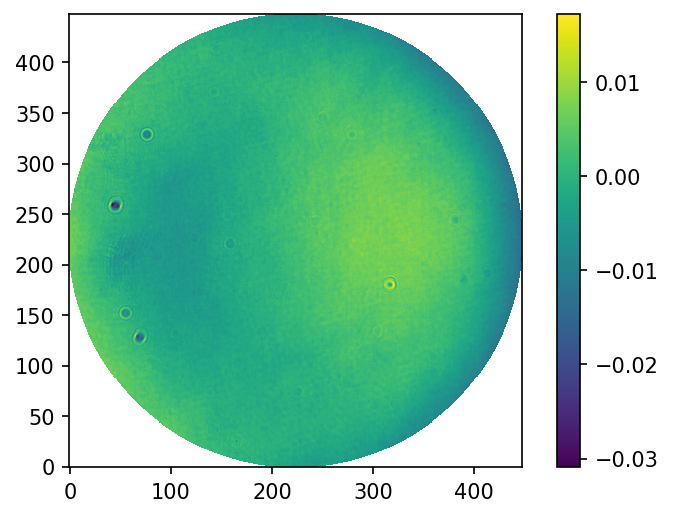

In [10]:
plt.figure(dpi=150)
plt.imshow(dfx.sn_map(data_set[0].value, mask), origin='lower')
plt.colorbar()

In [80]:
fm_num=8 # pick one mirror
tot_step=6
fits_folder = 'flat_mirrors/fixed_fits/'
ca_resize = 80

for ns in range(0, tot_step):
    print('Analyzing Step {0}'.format(ns))
    # call in the file
    fm_loc = 'flat_mirrors/2018_03_23/flat_2in_n{0}_100percent_step{1}.datx'.format(fm_num, ns)
    surf, mask, sp = dfx.open_datx(datx_file_loc=fm_loc, diam_ca100=50*u.mm)

    # tighten up the matrix by removing empty rows and columns
    surf, mask = dfx.mat_tight(surf, mask)
    
    # apply a resize
    ca_side = np.int(np.shape(mask)[0]*ca_resize/100)
    if ca_side % 2 !=0: # check resize is even
        ca_side -= 1 # decrease by 1
    
    

    # check that the matrix is even (required for the PSD code)
    if np.shape(surf)[0] % 2 != 0: # odd matrix
        surf, mask = dfx.mat_reduce(data=surf, mask=mask, side_reduce=1)

    # apply the changes onto the dictionary
    sp['diam_pix'] = np.shape(mask)[0]*u.pix
    sp['diam_mm'] = (sp['diam_pix'] * sp['lateral_res']).to(u.mm)

    # save the raw file
    raw_file = fits_folder+'flat_2in_n{0}_step{1}_raw'.format(fm_num, ns)
    #dfx.write_fits(surface=surf, mask=mask, surf_parms=sp, filename=raw_file, save_mask=False)

    #Convert surface data to phase'
    k_num = sp['wavelength'].to(surf.unit) / (2*np.pi*u.radian)
    surf_phase = surf / k_num

    # Calculate Zernike PTT presence in data and remove it
    #surf_fix_phase, w_ptt = zern.remove_ptt(data=surf_phase, mask=mask)
    
    # remove up to zernike 9
    z_weight = []
    surf_fix_phase = copy.copy(surf_phase) # intitialize 
    zn = [0, 1, 2, 3]
    for nv in zn:
        zm = np.linspace(-nv,nv,num=nv+1,endpoint=True).astype(int)
        for mv in zm:
            #print('Correcting zernike n={0} m={1}'.format(nv, mv))
            z_phase, w_val = zern.calc_zernike_proj(data=surf_phase, mask=mask, zn=nv, zm=mv)
            surf_fix_phase = surf_fix_phase - (z_phase*w_val)
            z_weight.append(w_val)

    # change the surface back into units of OPD
    surf_fix = surf_fix_phase * k_num
    
    # write data to a matrix
    if ns==0: # initialize first time
        data_set = np.zeros((tot_step, np.shape(mask)[0], np.shape(mask)[0])) # initialize first
    data_set[ns, :, :] = surf_fix.value

    # write all this to a FITS file
    fits_file = fits_folder+'flat_2in_n{0}_step{1}'.format(fm_num, ns)
    #dfx.write_fits(surface=surf_fix, mask=mask, surf_parms=sp, filename=fits_file)

# apply units to the data set
data_set *= surf_fix.unit

#print out the presence of data
j=0
zn = [0, 1, 2, 3]
print('{0:>2} | {1:>2} | {2:>2} | {3:>8}'.format('j', 'n', 'm', 'weight'))
for nv in zn:
    zm = np.linspace(-nv,nv,num=nv+1,endpoint=True).astype(int)
    for mv in zm:
        print('{0:2d} | {1:2d} | {2:2d} | {3:>8.5f}'.format(j, nv, mv, z_weight[j]))
        j+=1

Analyzing Step 0
Analyzing Step 1
Analyzing Step 2
Analyzing Step 3
Analyzing Step 4
Analyzing Step 5
 j |  n |  m |   weight
 0 |  0 |  0 |  5.30298
 1 |  1 | -1 | -2.07908
 2 |  1 |  1 | -0.04131
 3 |  2 | -2 |  0.00964
 4 |  2 |  0 | -0.03432
 5 |  2 |  2 |  0.01271
 6 |  3 | -3 | -0.00131
 7 |  3 | -1 |  0.00510
 8 |  3 |  1 | -0.01383
 9 |  3 |  3 |  0.00853


In [101]:
#print out the presence of data
j=0
zn = [0, 1, 2, 3]
print('Zernike presence (step 5)')
print('{0:>2} | {1:>2} | {2:>2} | {3:>8}'.format('j', 'n', 'm', 'weight'))
for nv in zn:
    zm = np.linspace(-nv,nv,num=nv+1,endpoint=True).astype(int)
    for mv in zm:
        print('{0:2d} | {1:2d} | {2:2d} | {3:>8.5f}'.format(j, nv, mv, z_weight[j]))
        j+=1

Zernike presence (step 5)
 j |  n |  m |   weight
 0 |  0 |  0 |  5.30298
 1 |  1 | -1 | -2.07908
 2 |  1 |  1 | -0.04131
 3 |  2 | -2 |  0.00964
 4 |  2 |  0 | -0.03432
 5 |  2 |  2 |  0.01271
 6 |  3 | -3 | -0.00131
 7 |  3 | -1 |  0.00510
 8 |  3 |  1 | -0.01383
 9 |  3 |  3 |  0.00853


In [83]:
coords = np.where(mask==True)
np.sum((data_set[0][coords].value)**2)/

<Quantity [-0.01538776, -0.01566358, -0.01594078, ..., -0.00885599,
           -0.00875142, -0.00844488] micron>

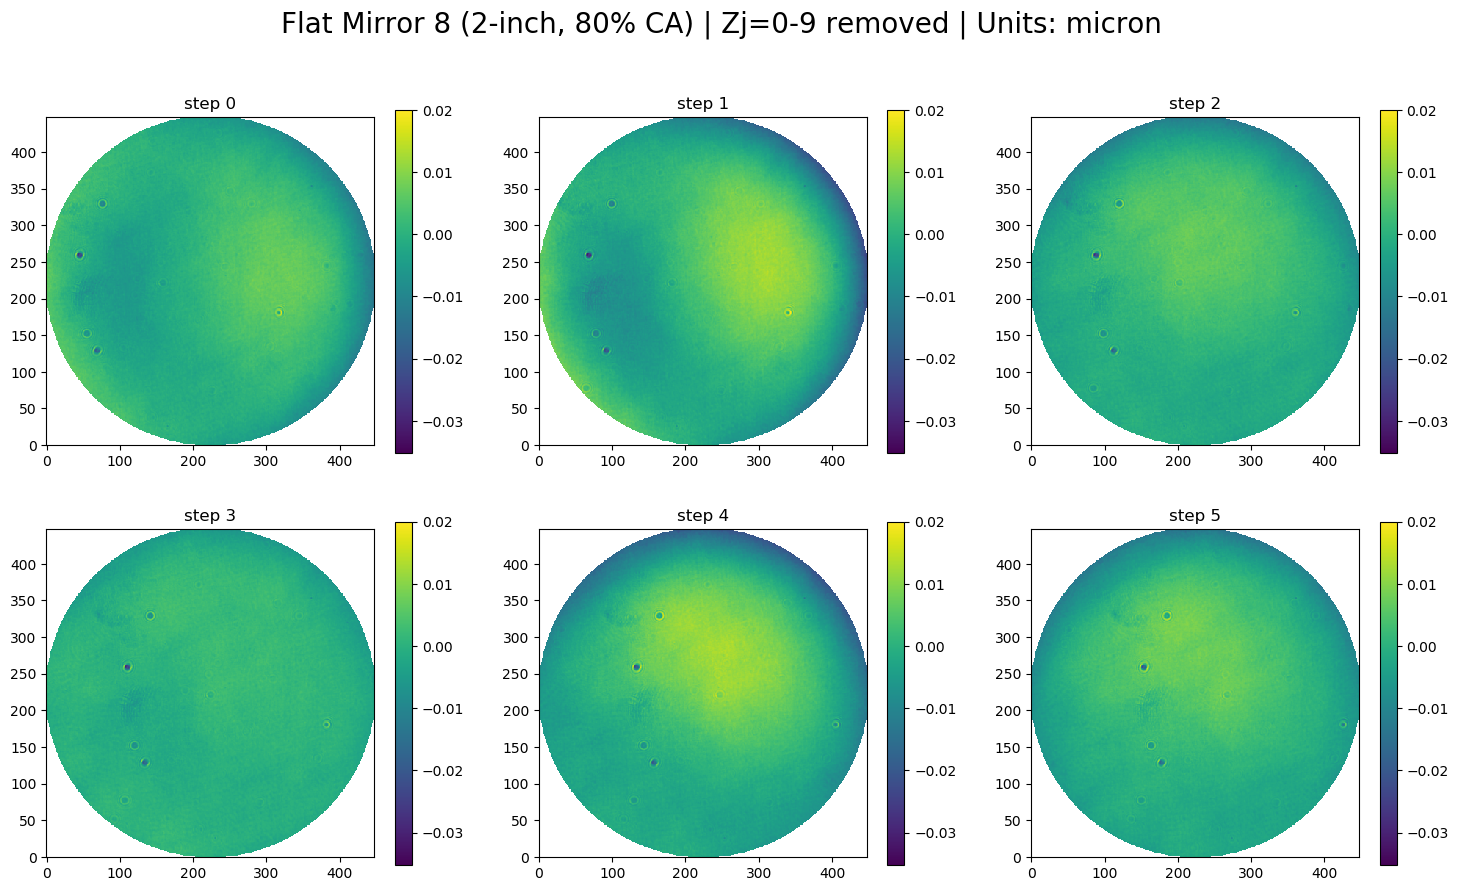

In [14]:
# calc min and max
vmin = np.amin(data_set.value)
vmax = np.amax(data_set.value)

plt.figure(figsize=[18, 10], dpi=100)
plt.suptitle('Flat Mirror 8 (2-inch, {0}% CA) | Zj=0-9 removed | Units: {1}'.format(ca_resize, data_set[0].unit), fontsize=20)
for n in range(0,tot_step):
    # calculate the RMS value
    
    order = '23{0}'.format(n+1)
    plt.subplot(order)
    plt.imshow(dfx.sn_map(data_set[n].value,mask), origin='lower', vmin=vmin, vmax=vmax)
    plt.title('step {0}'.format(n))
    plt.colorbar()

Text(0.5, 1.0, 'Median data (micron)')

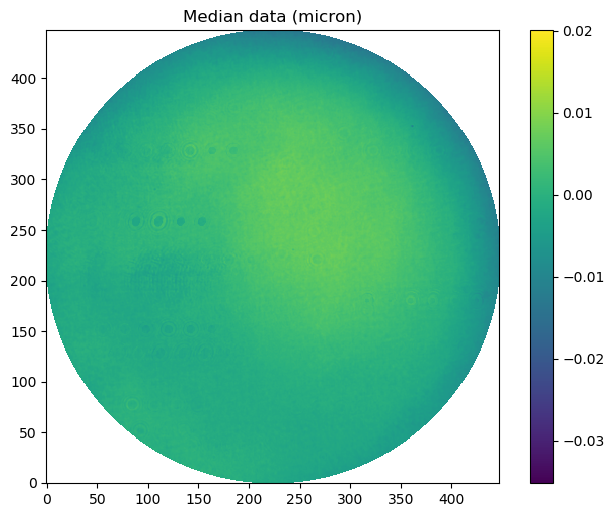

In [13]:
# flatten the data
flat_data = np.zeros((tot_step, np.product(np.shape(mask))))
for n in range(0, tot_step):
    flat_data[n] = np.reshape(data_set[n],np.product(np.shape(mask)))
# now calculate the median
med_data = np.median(flat_data, axis=0).reshape(np.shape(mask))
# show the plot of the median data
plt.figure(figsize=[8,6], dpi=100)
plt.imshow(dfx.sn_map(med_data,mask), origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Median data ({0})'.format(data_set.unit))

In [48]:
sp

{'wavelength': <Quantity 6.328e-07 m>,
 'scale_factor': 0.5,
 'units': 'micron',
 'lateral_res': <Quantity 8.91265597e-05 m / pix>,
 'diam_pix': <Quantity 560. pix>,
 'diam_mm': <Quantity 49.91087344 mm>}

In [85]:
# Let's look at the PSD with all the spots and the median.

fm_parms = {'ca' : 99, # of the 80% CA given
             'ovs': 4096,
             'diam_100CA': 50*u.mm, # not really useful but okay
             'surf_units': u.micron}

ntot = 6
fms=[]
for n in range(0,ntot):
    # write the step number
    n_step = 'step {0}'.format(n)
    
    # create the object
    t_fm = psd.surfPSD(surf_name = n_step,
                       ca_percent = fm_parms['ca'],
                       oversamp = fm_parms['ovs'])
    
    # load the file
    t_fm.load_surf(data=data_set[n],
                    wavelen=sp['wavelength'],
                    latres=sp['lateral_res'])

    # calculate the PSD
    t_fm.calc_psd()
    print('PSD for {0} complete'.format(n_step))
    
    # calculate the radial profile
    t_fm.calc_psd_radial(ring_width=5)
    print('Radial profile for {0} complete\n'.format(n_step))
    
    fms.append(t_fm)
    
print('All FM step PSD complete')

PSD for step 0 complete
Radial profile for step 0 complete

PSD for step 1 complete
Radial profile for step 1 complete

PSD for step 2 complete
Radial profile for step 2 complete

PSD for step 3 complete
Radial profile for step 3 complete

PSD for step 4 complete
Radial profile for step 4 complete

PSD for step 5 complete
Radial profile for step 5 complete

All FM step PSD complete


In [86]:
# generate the median PSD
# create the object
n_step = 'Median surface'
fm_med = psd.surfPSD(surf_name = n_step,
                   ca_percent = fm_parms['ca'],
                   oversamp = fm_parms['ovs'])

# load the file
fm_med.load_surf(data=med_data*data_set.unit,
                wavelen=sp['wavelength'],
                latres=sp['lateral_res'])

# calculate the PSD
fm_med.calc_psd()
print('PSD for {0} complete'.format(n_step))

# calculate the radial profile
fm_med.calc_psd_radial(ring_width=5)
print('Radial profile for {0} complete\n'.format(n_step))

PSD for Median surface complete
Radial profile for Median surface complete



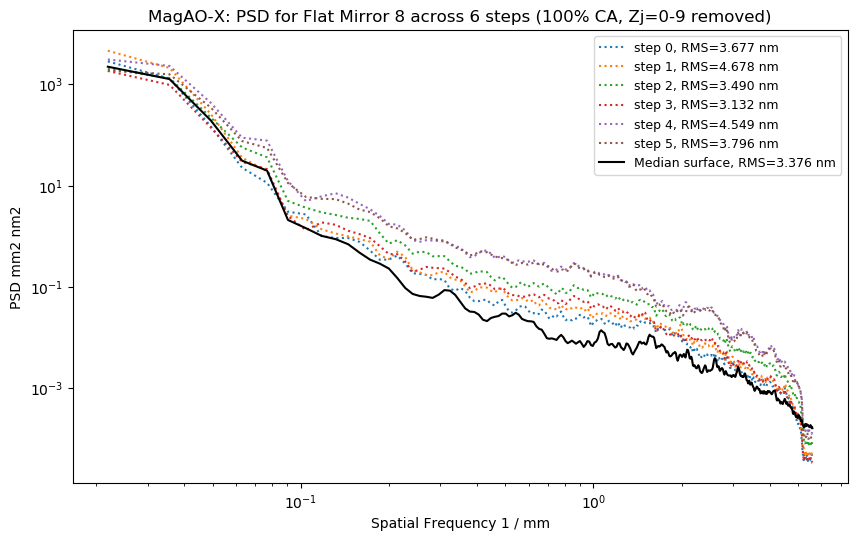

In [102]:
plt.figure(figsize=[10,6],dpi=100)
for obj in fms:
    plt.loglog(obj.k_radial.value, obj.psd_radial_cal.value, ':', label='{0}, RMS={1:.3f}'.format(obj.surf_name, np.sqrt(obj.var)))
plt.loglog(fm_med.k_radial.value, fm_med.psd_radial_cal.value, 'k', label='{0}, RMS={1:.3f}'.format(fm_med.surf_name, np.sqrt(fm_med.var)))
plt.xlabel('Spatial Frequency {0}'.format(fms[0].k_radial.unit))
plt.ylabel('PSD {0}'.format(fms[0].psd_radial_cal.unit))
plt.title('MagAO-X: PSD for Flat Mirror 8 across 6 steps (100% CA, Zj=0-9 removed)')
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(prop={'size':9})

In [33]:
np.sum(x,axis=1)

array([ 3, 12, 21])

In [59]:
n=3
np.linspace(-n, n, num=n+1, endpoint=True).astype(int)

array([-3, -1,  1,  3])